In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# pipelines
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_selector 

# preprocessing
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures

# model selection
from sklearn.model_selection import train_test_split, GridSearchCV

# model
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression, SGDRegressor
from sklearn.dummy import DummyClassifier

# metrics
from sklearn.metrics import mean_squared_error, r2_score, classification_report, RocCurveDisplay

# Tree and Ensemble Methods
## Live Demos

In [2]:
stockx_data = pd.read_csv("data/StockX-Data-Contest-2019-3.csv")

In [3]:
stockx_data

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,"$1,097",$220,9/24/16,11.0,California
1,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,$685,$220,11/23/16,11.0,California
2,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,$690,$220,11/23/16,11.0,California
3,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,"$1,075",$220,11/23/16,11.5,Kentucky
4,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,$828,$220,2/11/17,11.0,Rhode Island
...,...,...,...,...,...,...,...,...
99951,2/13/19,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,$565,$220,12/26/18,8.0,Oregon
99952,2/13/19,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,$598,$220,12/26/18,8.5,California
99953,2/13/19,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,$605,$220,12/26/18,5.5,New York
99954,2/13/19,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,$650,$220,12/26/18,11.0,California


### Data Processing Part

In [4]:
stockx_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99956 entries, 0 to 99955
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Order Date    99956 non-null  object 
 1   Brand         99956 non-null  object 
 2   Sneaker Name  99956 non-null  object 
 3   Sale Price    99956 non-null  object 
 4   Retail Price  99956 non-null  object 
 5   Release Date  99956 non-null  object 
 6   Shoe Size     99956 non-null  float64
 7   Buyer Region  99956 non-null  object 
dtypes: float64(1), object(7)
memory usage: 6.1+ MB


In [5]:
stockx_data.describe()

,Shoe Size
count,99956.000000
mean,9.344181
std,2.329588
min,3.500000
25%,8.000000
50%,9.500000
75%,11.000000
max,17.000000


In [6]:
stockx_data["Sale Price"]

0        $1,097
1          $685
2          $690
3        $1,075
4          $828
          ...  
99951      $565
99952      $598
99953      $605
99954      $650
99955      $640
Name: Sale Price, Length: 99956, dtype: object

In [7]:
stockx_data = stockx_data.rename(columns = lambda x: x.lower().replace(" ", "_"))

In [8]:
any(~stockx_data.sale_price.str.startswith("$"))

False

In [9]:
any(~stockx_data.retail_price.str.startswith("$"))

False

In [10]:
stockx_data.sale_price = stockx_data.sale_price.str.replace("$", "").str.replace(",", "").astype(float)

In [11]:
stockx_data.retail_price = stockx_data.retail_price.str.replace("$", "").str.replace(",", "").astype(float)

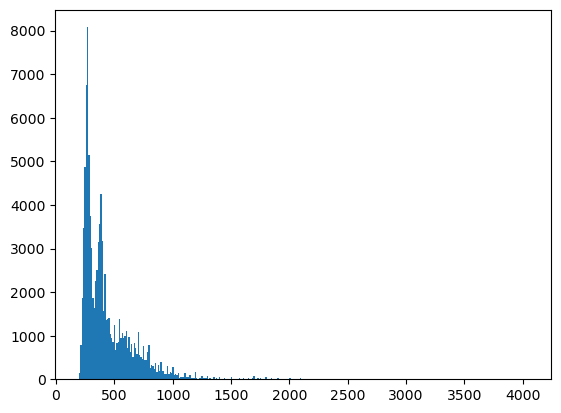

In [12]:
plt.hist(stockx_data.sale_price, bins = "auto")
plt.show()

Multi-modal distribution with an extremely huge tail.

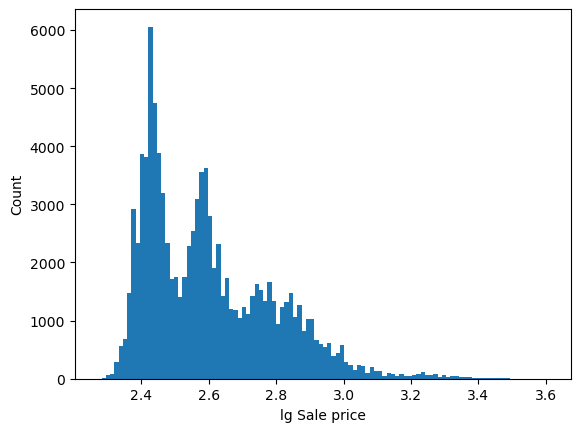

In [13]:
plt.hist(np.log10(stockx_data.sale_price), bins = "auto")
plt.xlabel("lg Sale price")
plt.ylabel("Count")
plt.show()

In [14]:
10 ** 2.7

501.18723362727246

In [15]:
10 ** 2.4

251.18864315095797

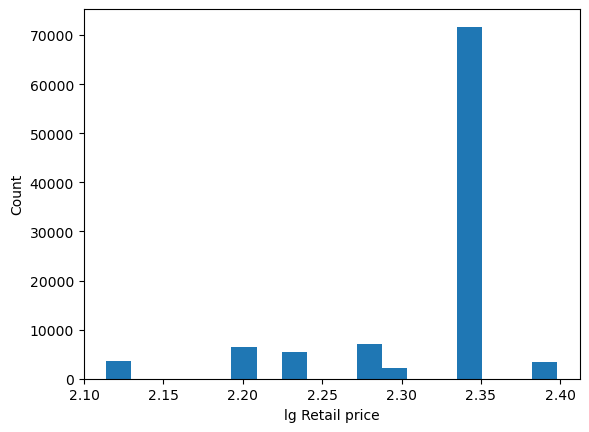

In [16]:
plt.hist(np.log10(stockx_data.retail_price), bins = "auto")
plt.xlabel("lg Retail price")
plt.ylabel("Count")
plt.show()

In [17]:
stockx_data.brand.value_counts()

brand
 Yeezy       72162
Off-White    27794
Name: count, dtype: int64

In [18]:
stockx_data.brand = stockx_data.brand.str.strip()

In [19]:
stockx_data.brand.value_counts()

brand
Yeezy        72162
Off-White    27794
Name: count, dtype: int64

In [20]:
stockx_data.buyer_region.value_counts()

buyer_region
California              19349
New York                16525
Oregon                   7681
Florida                  6376
Texas                    5876
New Jersey               4720
Illinois                 3782
Pennsylvania             3109
Massachusetts            2903
Michigan                 2762
Virginia                 2058
Ohio                     1890
Maryland                 1870
Washington               1863
Georgia                  1846
Arizona                  1398
North Carolina           1344
Delaware                 1242
Connecticut              1110
Indiana                  1026
Colorado                  954
Wisconsin                 840
Nevada                    790
Tennessee                 731
Minnesota                 725
Missouri                  660
South Carolina            570
Louisiana                 537
Kentucky                  488
Iowa                      460
Alabama                   457
Utah                      450
Oklahoma                  4

In [21]:
# Concat is a faster operation than merge.
stockx_data = pd.concat([
    stockx_data, 
    pd.get_dummies(stockx_data.buyer_region, drop_first = True).astype(int)],
    axis = 1
) # or axis = columns

In [22]:
stockx_data

,order_date,brand,sneaker_name,sale_price,retail_price,release_date,shoe_size,buyer_region,Alaska,Arizona,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,1097.0,220.0,9/24/16,11.0,California,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,685.0,220.0,11/23/16,11.0,California,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,690.0,220.0,11/23/16,11.0,California,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,1075.0,220.0,11/23/16,11.5,Kentucky,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,828.0,220.0,2/11/17,11.0,Rhode Island,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99951,2/13/19,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,565.0,220.0,12/26/18,8.0,Oregon,0,0,...,0,0,0,0,0,0,0,0,0,0
99952,2/13/19,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,598.0,220.0,12/26/18,8.5,California,0,0,...,0,0,0,0,0,0,0,0,0,0
99953,2/13/19,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,605.0,220.0,12/26/18,5.5,New York,0,0,...,0,0,0,0,0,0,0,0,0,0
99954,2/13/19,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,650.0,220.0,12/26/18,11.0,California,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
stockx_data = stockx_data.drop(columns = "buyer_region")

In [24]:
stockx_data.loc[99951]

order_date                                                  2/13/19
brand                                                         Yeezy
sneaker_name            adidas-Yeezy-Boost-350-V2-Static-Reflective
sale_price                                                    565.0
retail_price                                                  220.0
release_date                                               12/26/18
shoe_size                                                       8.0
Alaska                                                            0
Arizona                                                           0
Arkansas                                                          0
California                                                        0
Colorado                                                          0
Connecticut                                                       0
Delaware                                                          0
District of Columbia                            

In [25]:
dummies = pd.get_dummies(stockx_data.brand, drop_first = True)

In [26]:
dummies.loc[99951]

Yeezy    True
Name: 99951, dtype: bool

In [27]:
stockx_data = pd.concat([
    stockx_data, 
    pd.get_dummies(stockx_data.brand, drop_first = True).astype(int)],
    axis = 1
)

In [28]:
stockx_data = stockx_data.drop(columns = "brand")

In [29]:
stockx_data = stockx_data.drop(columns = ["sneaker_name"])

In [30]:
stockx_data

,order_date,sale_price,retail_price,release_date,shoe_size,Alaska,Arizona,Arkansas,California,Colorado,...,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,Yeezy
0,9/1/17,1097.0,220.0,9/24/16,11.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,9/1/17,685.0,220.0,11/23/16,11.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,9/1/17,690.0,220.0,11/23/16,11.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,9/1/17,1075.0,220.0,11/23/16,11.5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,9/1/17,828.0,220.0,2/11/17,11.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99951,2/13/19,565.0,220.0,12/26/18,8.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
99952,2/13/19,598.0,220.0,12/26/18,8.5,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
99953,2/13/19,605.0,220.0,12/26/18,5.5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
99954,2/13/19,650.0,220.0,12/26/18,11.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [31]:
stockx_data.order_date.str.split("/", expand = True)

,0,1,2
0,9,1,17
1,9,1,17
2,9,1,17
3,9,1,17
4,9,1,17
...,...,...,...
99951,2,13,19
99952,2,13,19
99953,2,13,19
99954,2,13,19


In [32]:
# Need a check for the values
stockx_data.order_date = pd.to_datetime(stockx_data.order_date)

C:\Users\aneli\AppData\Local\Temp\ipykernel_8648\1673989517.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stockx_data.order_date = pd.to_datetime(stockx_data.order_date)


In [33]:
# Need a check for the values
stockx_data.release_date = pd.to_datetime(stockx_data.release_date)

C:\Users\aneli\AppData\Local\Temp\ipykernel_8648\674464896.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stockx_data.release_date = pd.to_datetime(stockx_data.release_date)


In [34]:
# The date feature as a whole can be converted to timestamp 
# but then value information will be lost so it is better to threat then separately.
stockx_data

,order_date,sale_price,retail_price,release_date,shoe_size,Alaska,Arizona,Arkansas,California,Colorado,...,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,Yeezy
0,2017-09-01,1097.0,220.0,2016-09-24,11.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,2017-09-01,685.0,220.0,2016-11-23,11.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,2017-09-01,690.0,220.0,2016-11-23,11.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,2017-09-01,1075.0,220.0,2016-11-23,11.5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2017-09-01,828.0,220.0,2017-02-11,11.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99951,2019-02-13,565.0,220.0,2018-12-26,8.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
99952,2019-02-13,598.0,220.0,2018-12-26,8.5,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
99953,2019-02-13,605.0,220.0,2018-12-26,5.5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
99954,2019-02-13,650.0,220.0,2018-12-26,11.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [35]:
dates = pd.DataFrame({
    "order_day": stockx_data.order_date.dt.day, 
    "order_month": stockx_data.order_date.dt.month, 
    "order_year": stockx_data.order_date.dt.year,
    "release_day": stockx_data.release_date.dt.day,
    "release_month": stockx_data.release_date.dt.month,
    "release_year": stockx_data.release_date.dt.year
})

In [36]:
dates

,order_day,order_month,order_year,release_day,release_month,release_year
0,1,9,2017,24,9,2016
1,1,9,2017,23,11,2016
2,1,9,2017,23,11,2016
3,1,9,2017,23,11,2016
4,1,9,2017,11,2,2017
...,...,...,...,...,...,...
99951,13,2,2019,26,12,2018
99952,13,2,2019,26,12,2018
99953,13,2,2019,26,12,2018
99954,13,2,2019,26,12,2018


In [37]:
stockx_data = pd.concat([stockx_data, dates], axis = 1).drop(columns = ["order_date", "release_date"])

In [43]:
attributes = stockx_data.drop(columns = "sale_price")

In [44]:
targets = stockx_data.sale_price

In [45]:
attributes.dtypes.unique()

array([dtype('float64'), dtype('int64'), dtype('int32')], dtype=object)

In [46]:
targets.dtype

dtype('float64')

#### SGD Regression

In [39]:
sgd = SGDRegressor() # squared error - standard regression
# huber function - mean square with outliers; lloks like a half of a square
# classification - modified huber
# penalty - gives regularization
# SGD gives a linear regression but works with stochastic gradient descent rather than QRdecomposition
# and is more useful for more data and for models which must be made quickly
# learning rate for less steps for example
# the real algorithm which uses gradient descent is sgd

In [48]:
sgd.fit(attributes, targets)

SGDRegressor()

In [50]:
sgd.loss_functions

{'squared_error': (_loss.CyHalfSquaredError,),
 'huber': (_loss.CyHuberLoss, 0.1),
 'epsilon_insensitive': (sklearn.linear_model._sgd_fast.EpsilonInsensitive,
  0.1),
 'squared_epsilon_insensitive': (sklearn.linear_model._sgd_fast.SquaredEpsilonInsensitive,
  0.1)}

In [51]:
sgd.coef_

array([-5.79077773e+11,  1.57999709e+12,  2.70078774e+09,  2.95101925e+10,
       -2.12197798e+09,  1.21587228e+11, -1.58363522e+10, -2.12560857e+10,
        1.46873628e+10, -2.21224161e+10, -2.51428464e+11,  8.51962890e+10,
        4.00308760e+10,  1.32315920e+10,  1.31018944e+11, -1.08534100e+10,
       -5.63802108e+10, -2.94418449e+10,  2.77069327e+10, -7.74665920e+09,
        6.35703265e+08, -5.35169920e+09, -6.87802818e+10, -1.53385357e+11,
        3.22304029e+10, -3.46757391e+09,  1.93395185e+10,  1.65820148e+10,
       -2.66526964e+10, -2.78430283e+10,  4.26576663e+10, -1.13838154e+11,
       -3.89002344e+09, -3.53329486e+10, -2.42076397e+10, -1.74107590e+10,
        1.36098549e+10,  3.78798135e+10, -1.00418869e+11,  9.55496967e+10,
        1.40287044e+10, -7.79205117e+09, -1.31688917e+10, -6.54914923e+09,
        1.32730111e+11,  8.65653012e+10,  6.37842495e+09,  2.18067475e+11,
       -1.21280563e+11,  1.31463853e+10,  3.24826185e+09, -9.85541616e+09,
       -8.92955458e+10,  

Coeficients show a problem with data scaling. Gradient descent is not steady when it comes to scaling while linear regression is resistant.

In [53]:
sgd.intercept_ # A very big intercept showing there is a problem

array([-3.77970913e+08])

In [54]:
targets.mean() # One more reason proving that the intercept is not right

np.float64(446.63471927648163)

This all means that there is strongly correlated data

In [55]:
# scaling to be performed
attributes_scaled = MinMaxScaler().fit_transform(attributes)

In [57]:
sgd.fit(attributes_scaled, targets)

SGDRegressor()

In [58]:
sgd.coef_

array([  15.00778564,   40.53747945,    4.49637126,   29.16927786,
         15.76482898,   43.19540036,   19.35217733,    7.68984459,
         94.87658667,   28.9446818 ,   22.11729641,   14.12625052,
         28.38186637,   -4.05105653,   16.14697921,   17.04790074,
         32.78932167,   26.7489404 ,   61.64090193,   14.78865497,
          1.84191127,   17.72366177,   23.84752951,   25.20023687,
         20.0056096 ,    5.05012568,   20.28429118,    8.65805696,
         21.89964275,   53.49072017,   12.495392  ,   31.27189319,
         20.56956133,   32.91659305,   10.48432481,    6.67581673,
         12.38979502,   15.24684818,   73.6225416 ,   20.78916063,
          9.72289502,   22.42557042,    8.41916156,   25.8896707 ,
         13.91537795,   17.36109443,   10.05833582,   25.95601589,
         25.88292305,    5.89813387,   23.62629098,    4.93928749,
       -366.39239314,    0.74239252, -187.11230437, -216.88750163,
        -48.30816751,  -33.50471481, -480.23164062])

The coeficients are quite big again.

In [60]:
sgd.intercept_  

array([1220.43067424])

There are a lot of things for fixing but the model is more stable now. 
SGD has been completed without many problems.

SGD helps for classification too. Logistic regression does batch GD.

The count of data in one mini-batch cannot be seen.

If more data is needed and not one record for mini-batch as SGD does, an optimizer should be used. optimizer = solver in sklearn (the algor ithm used for training)